# Loading dependencies and model

In [1]:
import os
import torch
from torchvision import datasets, transforms
from utils import loaders_by_classes, filter_loaders, balance
from classNet import ConvNet, submodel # for torch load
import matplotlib.pyplot as plt

In [2]:
_model = torch.load('./models/all_class.pth', weights_only=False)
_model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0,), (1,))  # Normalize images
])

test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
num_workers = os.cpu_count()
test_loaders = loaders_by_classes(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

# Choose class to Test

In [5]:
class_name = '7 - seven'
class_loader = test_loaders[class_name]


In [ ]:
bal = balance(test_loaders)
n_items_class = bal[class_name]
n_tot = 0
for key, val in bal.items():
    if key != class_name:
        n_tot += val
proportion = n_items_class / n_tot
balanced_batch_size = (1 - proportion) * batch_size / proportion

In [ ]:
filtered_loader = filter_loaders(test_loaders, class_name, balanced_batch_size, shuffle=True, num_workers=num_workers)

# Submodel

In [8]:
model = submodel(_model, 7)
model.to(device)


ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

# Gradients pour classic Loss 

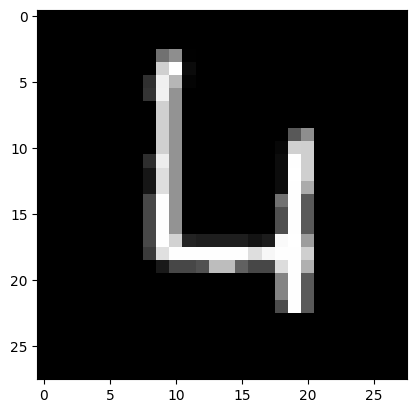

In [9]:
input = next(iter(filtered_loader))
plt.imshow(input[0][0].squeeze(), cmap='gray')

In [10]:
def get_param_grad_1(model, input, back_lay_num = 1):
    input_tensor, label_tensor = input
    input_tensor = input_tensor.to(device)
    label_tensor = label_tensor.to(device)

    # Assurez-vous que l'entrée a bien requires_grad activé
    input_tensor.requires_grad_(True)

    # Passer en avant jusqu'au dernier layer paramétrique
    model.zero_grad()
    output = model(input_tensor)

    # Calcul de la perte et rétropropagation
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, label_tensor)
    loss.backward()

    # Récupérer le gradient des poids et biais du layer paramétrique
    layer = list(model.children())[- back_lay_num]  # Dernier layer du modèle

    # Liste pour stocker les gradients de chaque paramètre
    grad_params = []

    for param in layer.parameters():
        # Aplatir les gradients des paramètres (poids et biais)
        grad_params.append(param.grad.flatten())  # Aplatir les gradients des poids et biais

    return grad_params

In [11]:
grad_1 = get_param_grad_1(model, input)

In [12]:
grad_1

[tensor([ 3.1297e-05,  4.5581e-05,  1.3455e-04,  ..., -1.0026e+00,
          3.2846e-06,  0.0000e+00], device='mps:0'),
 tensor([ 0.0001,  0.0106, -0.0063,  0.0086,  0.0158, -0.0077, -0.0005,  0.0976,
         -0.1182], device='mps:0')]

# Gradient pour Target Loss

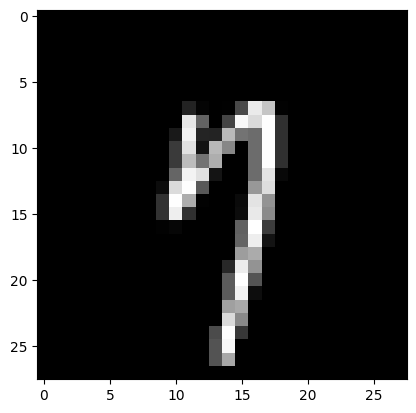

In [13]:
input = next(iter(class_loader))
# plot un example d'image input
plt.imshow(input[0][0].squeeze(), cmap='gray')

In [46]:
_model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [56]:
torch.exp(model(input[0].to(device))[:,:7])

tensor([[4.2597e-03, 2.9180e-01, 5.2444e-04, 2.3075e-02, 2.0054e-01, 2.7490e-02,
         7.5889e-04],
        [8.2640e-09, 4.3622e-02, 1.1558e-01, 8.1650e-01, 2.9861e-05, 7.0842e-08,
         5.0550e-13],
        [2.5138e-07, 4.7007e-02, 1.9535e-02, 5.3996e-03, 2.8063e-06, 2.3294e-06,
         3.8001e-13],
        [4.3968e-05, 4.1172e-06, 9.8676e-01, 1.2892e-02, 1.7187e-09, 2.4299e-09,
         2.8671e-12],
        [9.2030e-08, 3.0545e-02, 8.7790e-01, 8.6705e-02, 4.5163e-05, 1.1730e-05,
         1.3516e-09],
        [1.1487e-08, 6.6002e-03, 1.7978e-02, 4.0413e-03, 6.5621e-04, 1.7902e-08,
         9.8922e-13],
        [2.2967e-05, 5.4231e-03, 9.8295e-01, 1.4081e-03, 6.2594e-07, 1.9822e-09,
         6.9822e-11],
        [1.2732e-04, 1.0058e-03, 1.9968e-05, 9.9577e-04, 9.0202e-04, 4.7851e-03,
         7.9604e-09],
        [3.4042e-09, 2.5014e-02, 1.5310e-02, 9.5008e-01, 3.4701e-08, 4.5710e-10,
         3.7142e-14],
        [2.2387e-08, 8.8648e-02, 7.9922e-03, 9.0307e-01, 6.0609e-05, 3.52

In [71]:
base_output = _model(input[0].to(device))
trun_output = model(input[0].to(device))

subbase_output = torch.cat([base_output[:,:7], base_output[:,7+1:]], dim=1)

go_exp_base = torch.exp(subbase_output)
go_exp_trun = torch.exp(trun_output)

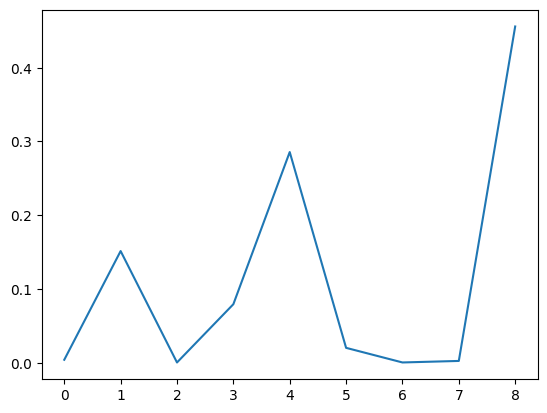

In [77]:
plt.plot(go_exp_trun.detach().cpu().numpy()[0])

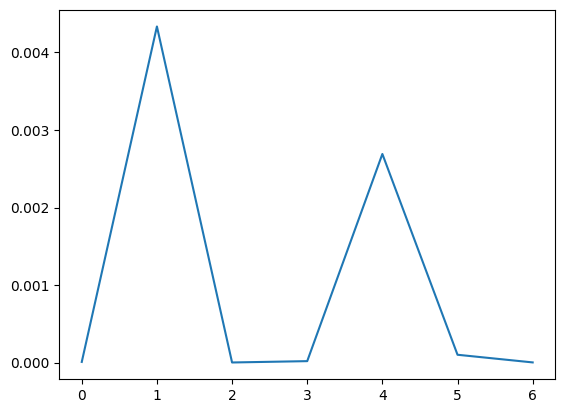

In [ ]:
output_logits = torch.exp(_model(input[0].to(device))[:, :7], dim=1)
plt.plot(output_logits.detach().cpu().numpy()[0])

In [150]:
def get_param_grad_2(model, input, back_lay_num = 1):
    input_tensor, label_tensor = input
    input_tensor = input_tensor.to(device)
    label_tensor = label_tensor.to(device)

    # Assurez-vous que l'entrée a bien requires_grad activé
    input_tensor.requires_grad_(True)

    # Cible : couche à surveiller
    layers = list(model.children())
    layer = layers[-back_lay_num]

    # Variable pour stocker les activations
    activations = None

    # Hook pour capturer les activations
    def hook_fn(module, input, output):
        nonlocal activations
        activations = output

    # Enregistrement du hook
    layer.register_forward_hook(hook_fn)
    
    # Passer en avant jusqu'au dernier layer paramétrique
    model.zero_grad()
    output = model(input_tensor)

    # activation correspond à la sortie de la couche AVANT log_softmax 
    _activations = activations.detach()
    print(activations)
    print(torch.mean(_activations, dim=0, keepdim=True))
    target = _activations - torch.mean(_activations, dim=0, keepdim=True)
    # target = - torch.ones(9).to(device)

    print(target.requires_grad)
    # Calcul de la perte et rétropropagation
    loss = torch.nn.functional.mse_loss(activations, target)
    loss.backward()

    # Liste pour stocker les gradients de chaque paramètre
    grad_params = []

    for param in layer.parameters():
        # Aplatir les gradients des paramètres (poids et biais)
        grad_params.append(param.grad.flatten())  # Aplatir les gradients des poids et biais

    return grad_params

In [149]:
model.eval()
grad_2 = get_param_grad_2(model, input)

tensor([[ -4.5533,   1.6713,  -6.3393,  -3.7737,   1.1944,  -2.0883,  -5.9071,
          -6.6814,   1.9590],
        [ -9.6524,  -4.1537,   1.4024,   0.9584,  -5.3069,  -9.6900, -19.1455,
          -3.1929,  -1.1751],
        [ -9.1936,  -2.4367,  -1.2555,  -0.1916,  -8.4482,  -6.5464, -19.3147,
          -2.5727,   2.8894],
        [ -5.4379,  -3.9553,   5.7606,   2.4984, -11.9779, -11.3161, -21.8194,
          -6.6440,  -1.0480],
        [-12.9192,   1.7978,   0.9373,   2.6922,  -7.3518,  -9.2857, -19.8641,
          -5.8674,  -0.6181],
        [-13.4957,  -3.4620,  -4.1966,   0.7654,  -0.8965, -12.7713, -20.6965,
         -10.0567,   4.1380],
        [-10.8875,   1.6282,   2.2260,   2.9760,  -9.5663, -12.5690, -22.1206,
          -5.8285,  -1.8824],
        [ -9.0897,  -1.0387,  -7.7430,  -3.2481,  -2.6396,  -2.9173, -14.1101,
          -4.9273,   2.3592],
        [ -9.3960,  -1.2017,   2.3871,   3.9594,  -9.8436, -12.7597, -22.9854,
          -6.5009,  -0.5882],
        [-10.6547, 

# Calcul Masking

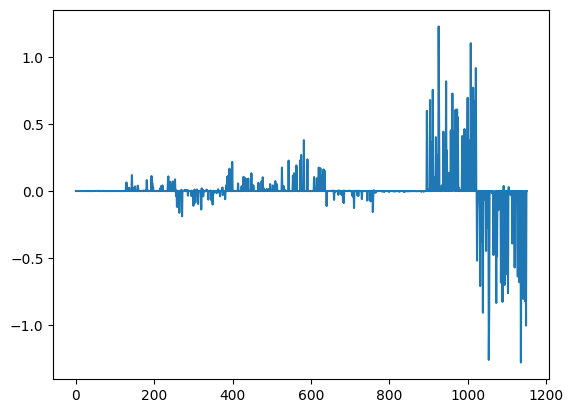

In [132]:
plt.plot(grad_1[0].detach().cpu().numpy())

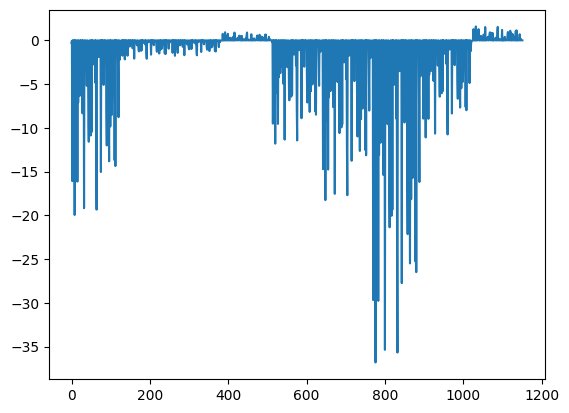

In [133]:
plt.plot(grad_2[0].detach().cpu().numpy())

In [139]:
mask = [(grad_1[0] * grad_2[0])> 0, (grad_1[1] * grad_2[1]) > 0]
torch.sum(mask[0]) + torch.sum(mask[1])

tensor(196, device='mps:0')

In [146]:
mask[0]*grad_2[0]*torch.abs(grad_1[0])

tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., 0.0000e+00, 2.2136e-08,
        0.0000e+00], device='mps:0')

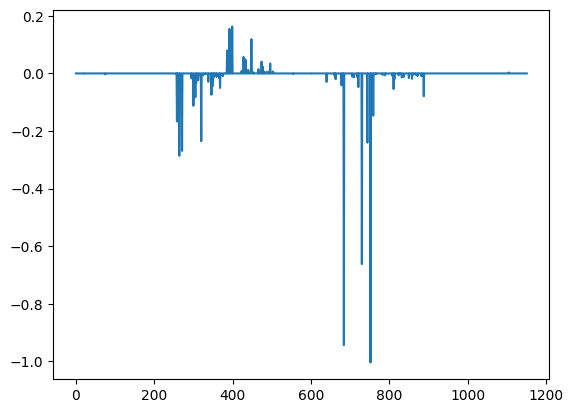

In [147]:
new_grad = [grad_2[0] * torch.abs(grad_1[0]) * mask[0], grad_2[1] * torch.abs(grad_1[1]) * mask[1]]
plt.plot(new_grad[0].detach().cpu().numpy())

In [ ]:
back_lay_num = 1
layer = list(model.children())[- back_lay_num]
params = layer.parameters()
list_params = list(params)
list_params[0].grad = 3000 * list_params[0].grad 
list_params[0].grad = 

tensor([[-1.8501e+06, -1.9627e+05, -1.4078e+08,  ..., -2.8171e+06,
         -2.3242e+05,  0.0000e+00],
        [ 3.6963e+05,  1.0735e+05,  1.4034e+06,  ...,  9.3147e+05,
         -5.2295e+04,  0.0000e+00],
        [ 1.6505e+04,  9.4429e+04,  4.6717e+07,  ...,  1.8975e+06,
         -2.1557e+05,  0.0000e+00],
        ...,
        [-4.6746e+06, -2.9919e+05, -3.0200e+08,  ..., -5.5355e+06,
         -4.3789e+05,  0.0000e+00],
        [-7.1208e+05, -9.4640e+04, -8.2323e+07,  ..., -1.1880e+06,
         -3.5822e+05,  0.0000e+00],
        [ 4.1831e+04, -5.7927e+04,  1.6109e+07,  ..., -1.4677e+06,
          1.9153e+05,  0.0000e+00]], device='mps:0')

In [ ]:
wgt, bias = list_params[0], list_params[1]
wgt, bias

(Parameter containing:
 tensor([[-0.1386,  0.1189, -0.1357,  ...,  0.0622,  0.0444, -0.0596],
         [ 0.0602,  0.0746,  0.0614,  ...,  0.0468, -0.1018, -0.0262],
         [-0.2365,  0.0751,  0.0738,  ...,  0.0325,  0.0142, -0.0390],
         ...,
         [-0.1448, -0.1523,  0.0451,  ..., -0.1763, -0.0253, -0.0100],
         [ 0.0359, -0.0877, -0.0979,  ...,  0.1001, -0.1611,  0.0632],
         [ 0.0805,  0.0698,  0.0568,  ..., -0.1275,  0.0459,  0.0399]],
        device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0903,  0.0220, -0.0523,  0.0591,  0.0151, -0.0137,  0.0476, -0.0684,
          0.0690, -0.0051], device='mps:0', requires_grad=True))

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)